In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import stan
import arviz as az

import nest_asyncio
nest_asyncio.apply()

In [8]:
# Set global set
global_rng = np.random.default_rng(42)

# Fix true probabilities for simulation study
true_probs = {
    'corr': 35662/63875,
    'sem': 2634/63875,
    'form': 3161/63875,
    'mix': 1587/63875,
    'unrel': 2303/63875,
    'neolog': 6049/63875,
    'abneo': 1821/63875,
    'nonnam': 10658/63875
}


# Simulate data
### Our code here
y = global_rng.multinomial(n=1000, pvals=list(true_probs.values()))
pd.DataFrame(y[:, None].T, columns=true_probs.keys(), index=['responses'])

,corr,sem,form,mix,unrel,neolog,abneo,nonnam
responses,568,29,41,29,44,101,35,153


In [9]:
true_probs

{'corr': 0.5583091976516634,
 'sem': 0.04123679060665362,
 'form': 0.049487279843444226,
 'mix': 0.024845401174168297,
 'unrel': 0.036054794520547946,
 'neolog': 0.09470058708414873,
 'abneo': 0.02850880626223092,
 'nonnam': 0.16685714285714287}

### Parameters and Model

The Aphasia MPT model is depicted in the following figure:

<img src="aphasia_mpt.png" width=65% height=65% />


The table below lists the four types of responses (categories):


| Response (Category) | Description  | Probability |
| --- | --- | --- |
| C | The response matches the target. Ex: Cat | $a\times b\times c\times d\times e\times f$ |
| S | The response is a word with only a semantic relation to the target. Ex: Dog | $a\times b\times (1-c)\times f$ |
| F | The response is a word with only a phonological relation to the target. Ex: Hat | $a\times b\times c\times(g-f\times g +f-f\times d)$ |
| M | The response is a word with both a semantic and phonological relation the target. Ex: Rat| $a\times b\times c\times d\times(1-e)\times f$ |
| U | The response is a word with neither a semantic nor a phonological relation to the target. Ex: Fog | $a\times((1-f)\times(h-b\times c\times h)+f\times(1-b))$ |
| N | The response is not a word, but it has a phonological relation to the target. Ex: Cag | $a\times b\times c\times(-g-f+f\times g+1)$ |
| AN | The response is not a word, nor does it have a phonological relation to the target. Ex: Rog | $a\times((1-f)\times(1-h)\times(1-b\times c))$ |
| NA | All other responsess. |$1-a$  |

In [16]:
aphasia_mpt_model_code = """
data {
  int<lower=1> N; // Number of trials
  int<lower=1> K; // Number of categories
  array[K] int<lower=0, upper=N> freqs;
}

parameters {
  real<lower = 0, upper=1> a;
  real<lower = 0, upper=1> b;
  real<lower = 0, upper=1> c;
  real<lower = 0, upper=1> d;
  real<lower = 0, upper=1> e;
  real<lower = 0, upper=1> f;
  real<lower = 0, upper=1> g;
  real<lower = 0, upper=1> h;
}

transformed parameters {
  // Model equations go here
  // Prob. Correct
  // Prob. Semantic
  // Prob. Formal
  // Prob. Mixed
  // Prob. Unrelated
  // Prob. Neologism
  // Prob. Absolute Neologism
  // Prob. Nonnaming Attempt
  simplex[8] theta;
  theta[1] = a*b*c*d*e*f*1;
  theta[2] = a*b*(1-c)*f;
  theta[3] = a*b*c*(g-f*g+f-f*d);
  theta[4] = a*b*c*d*(1-e)*f;
  theta[5] = a * ((1-f)*(h-b*c*h)+f*(1-b));
  theta[6] = a*b*c*(1-g-f+f*g);
  theta[7] = a*((1-f)*(1-h)*(1-b*c));
  theta[8] = 1-a;
}

model {
  target+=beta_lpdf(a| 1,1);
  target+=beta_lpdf(b| 1,1);
  target+=beta_lpdf(c| 1,1);
  target+=beta_lpdf(d| 1,1);
  target+=beta_lpdf(e| 1,1);
  target+=beta_lpdf(f| 1,1);
  target+=beta_lpdf(g| 1,1);
  target+=beta_lpdf(h| 1,1);
  target+=multinomial_lpmf(freqs | theta);
}

generated quantities{
  array[K] int pred_freqs;
  pred_freqs = multinomial_rng(theta, N);
}
"""

In [17]:
### Compile, fit, and diagnose model
### Your code here
stan_dict = {
    'freqs': y,
    'N': 1000,
    'K': 8
}

# Compile model
posterior = stan.build(aphasia_mpt_model_code, data=stan_dict, random_seed=42)


# Sample (i.e., inverse inference)
fit = posterior.sample(num_chains=4, num_samples=2500, num_warmup=1000)

Building: 0.1s
Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.2s
Building: 3.3s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 5.0s
Building: 5.1s
Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s
Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s
Building: 6.9s
Building: 

Building: 21.9s, done.
Sampling:   0%
Sampling:  25% (3500/14000)
Sampling:  50% (7000/14000)
Sampling:  75% (10500/14000)
Sampling: 100% (14000/14000)
Sampling: 100% (14000/14000), done.
Messages received during sampling:
  Gradient evaluation took 9e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.08 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_7mcatem6_namespace::log_prob: theta is not a valid simplex. theta[6] = -4.40415e-17, but should be greater than or equal to 0 (in '/tmp/httpstan_gv1t65b6

In [19]:
### Parameter recovery and predictions
# Estimation summary, convergence, and efficiency diagnostics
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.846,0.011,0.825,0.867,0.000,0.000,9038.0,6205.0,1.0
b,0.923,0.010,0.903,0.941,0.000,0.000,8592.0,6658.0,1.0
c,0.943,0.009,0.925,0.961,0.000,0.000,8849.0,5934.0,1.0
d,0.987,0.012,0.964,1.000,0.000,0.000,2762.0,2245.0,1.0
e,0.950,0.009,0.934,0.967,0.000,0.000,8233.0,5999.0,1.0
f,0.798,0.016,0.767,0.828,0.000,0.000,4178.0,2495.0,1.0
g,0.253,0.054,0.147,0.350,0.001,0.001,2655.0,1376.0,1.0
h,0.049,0.045,0.000,0.134,0.000,0.000,7168.0,4281.0,1.0
theta[0],0.551,0.015,0.522,0.579,0.000,0.000,11554.0,7971.0,1.0
theta[1],0.035,0.006,0.024,0.047,0.000,0.000,8351.0,5971.0,1.0


In [22]:
true_probs

{'corr': 0.5583091976516634,
 'sem': 0.04123679060665362,
 'form': 0.049487279843444226,
 'mix': 0.024845401174168297,
 'unrel': 0.036054794520547946,
 'neolog': 0.09470058708414873,
 'abneo': 0.02850880626223092,
 'nonnam': 0.16685714285714287}

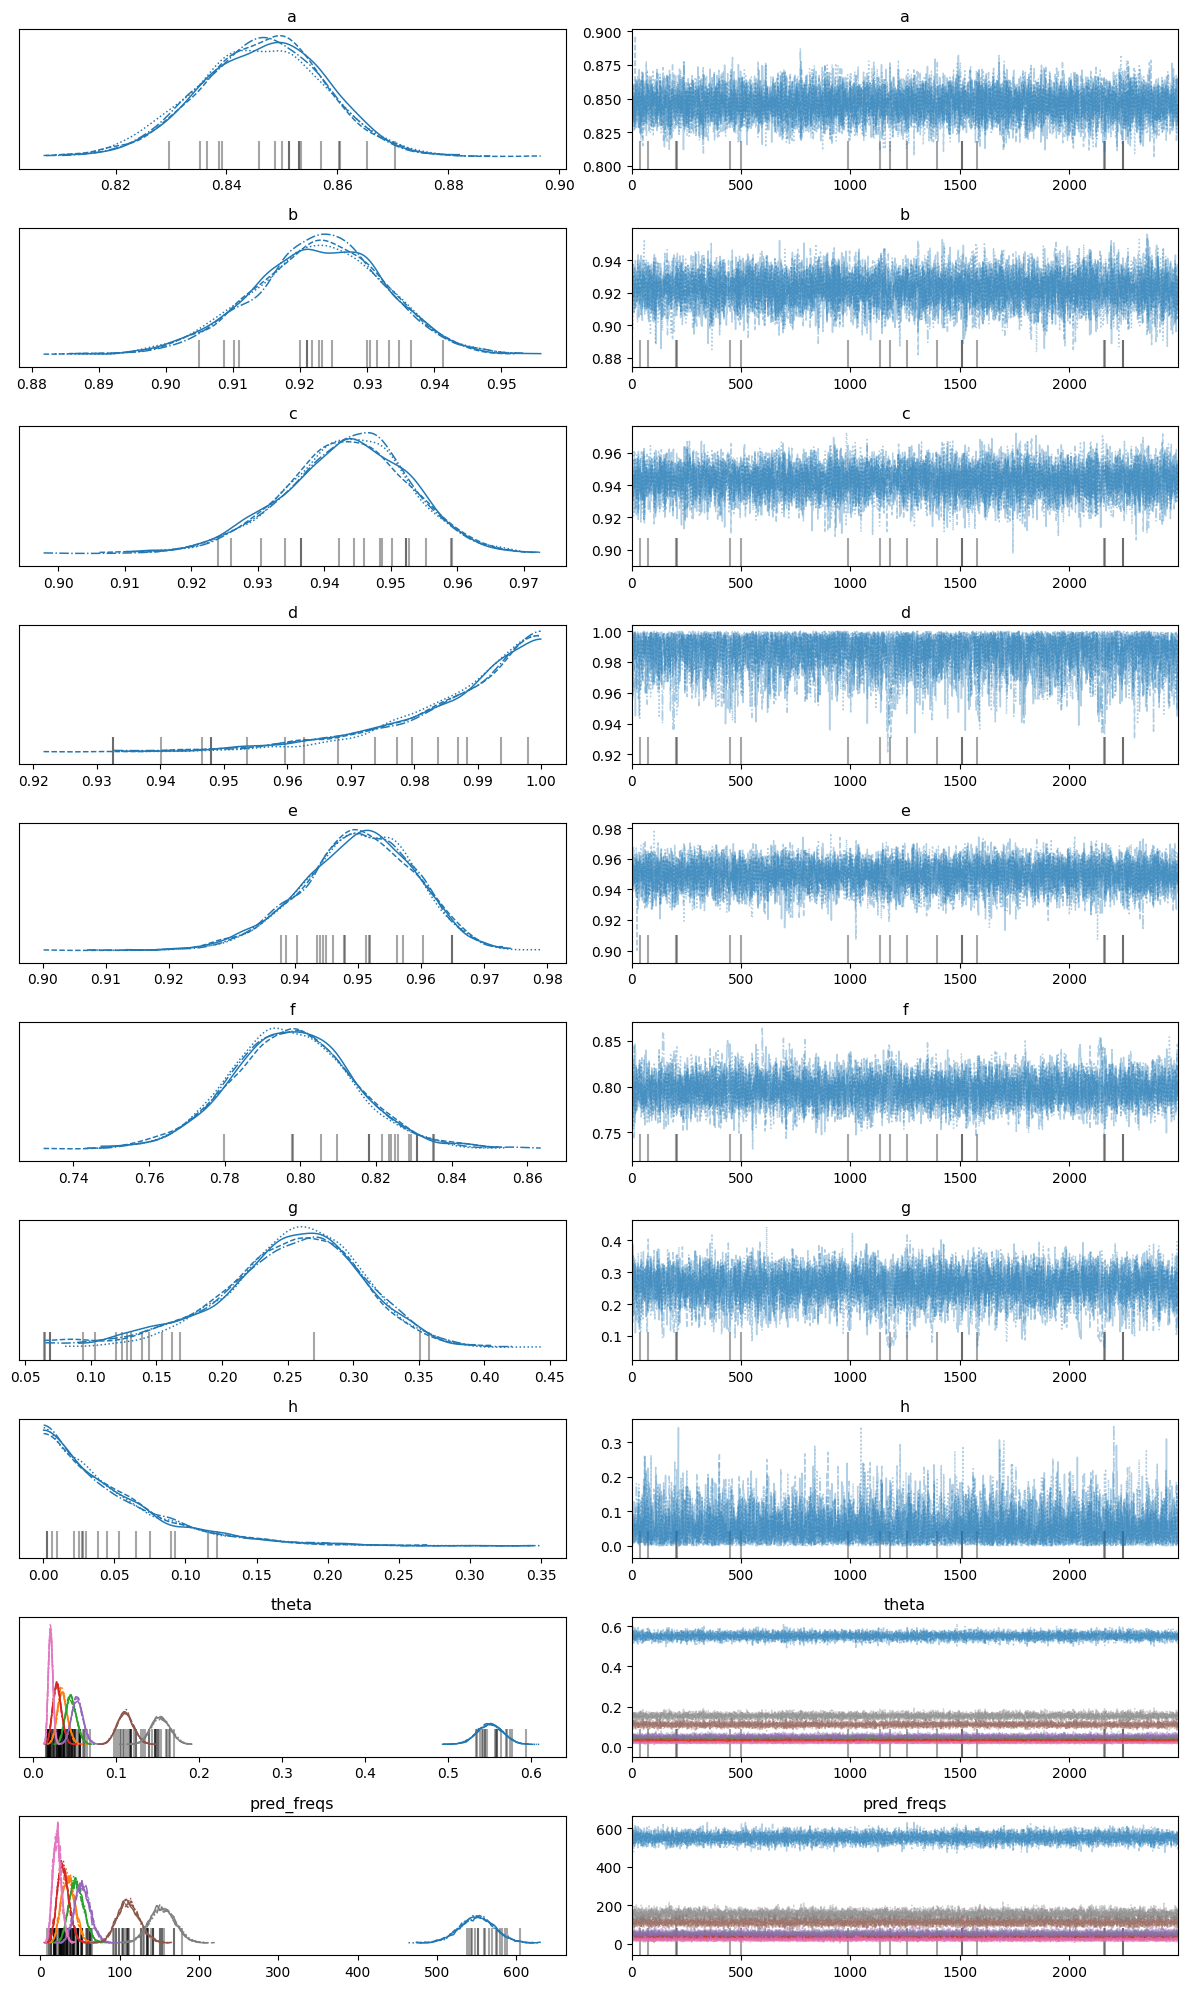

In [21]:
# Traceplots and marginals - visual convergence checks
azarr = az.plot_trace(fit)
plt.tight_layout()